In [461]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib as mp
from shapely.geometry import Point, Polygon
import altair as alt
import numpy as np
import requests
import json
import warnings
from matplotlib.colors import ListedColormap

alt.renderers.enable('notebook')
alt.themes.enable('opaque')

warnings.filterwarnings('ignore')
%matplotlib inline

In [513]:
def download_json():
    url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
    resp = requests.get(url)
    return resp.json()

In [514]:
def gen_base(geojson):
    '''Generates baselayer of DC ANC map'''
    base = alt.Chart(alt.Data(values=geojson)).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=400,
        height=400
    )
    return base
data = download_json()
base_layer = gen_base(geojson=data)

In [516]:
gdf = gpd.GeoDataFrame.from_features((data))

In [517]:
gdf['name'] = gdf['name'].apply(lambda x: x.lower())

In [501]:
pred = pd.read_csv('./data/normError.csv')

In [502]:
pred = pred.rename(columns={'Unnamed: 0':'name'})

In [503]:
pred =pred[np.bitwise_and(pred<200,pred>0)].fillna(0)

In [504]:
pred_copy = pred.drop('name',1)

In [506]:
pred_copy = pred_copy*0.01

In [520]:
pred_copy['name'] = pred['name']

In [521]:
gdf = gdf.merge(pred_copy, on='name', how='left')

In [522]:
gdf['center_lon'] = gdf['geometry'].centroid.x
gdf['center_lat'] = gdf['geometry'].centroid.y

In [523]:
choro_json = json.loads(gdf.to_json())
choro_data = alt.Data(values=choro_json['features'])

In [524]:
def gen_map(geodata, color_column, title):
    '''Generates LA map with population choropleth and neighborhood labels'''
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1,
    ).encode(
    ).properties(
        width=800,
        height=800
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        fill='lightgray',
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme='yelloworangered'),
                  title = ""),
        tooltip = ['properties.name:O',color_column + ':Q'])

    # Add Labels Layer
    labels = alt.Chart(geodata).mark_text(baseline='top'
                                          
                                          
     ).properties(
        width=100,
        height=200
     ).encode(
         longitude='properties.center_lon:Q',
         latitude='properties.center_lat:Q',
         text='properties.name:O',
         size=alt.value(7),
         opacity=alt.value(1)
     )

    return base + choro + labels

In [527]:
map_2003 = gen_map(geodata=choro_data, color_column='properties.2000', title='Relative Errors')


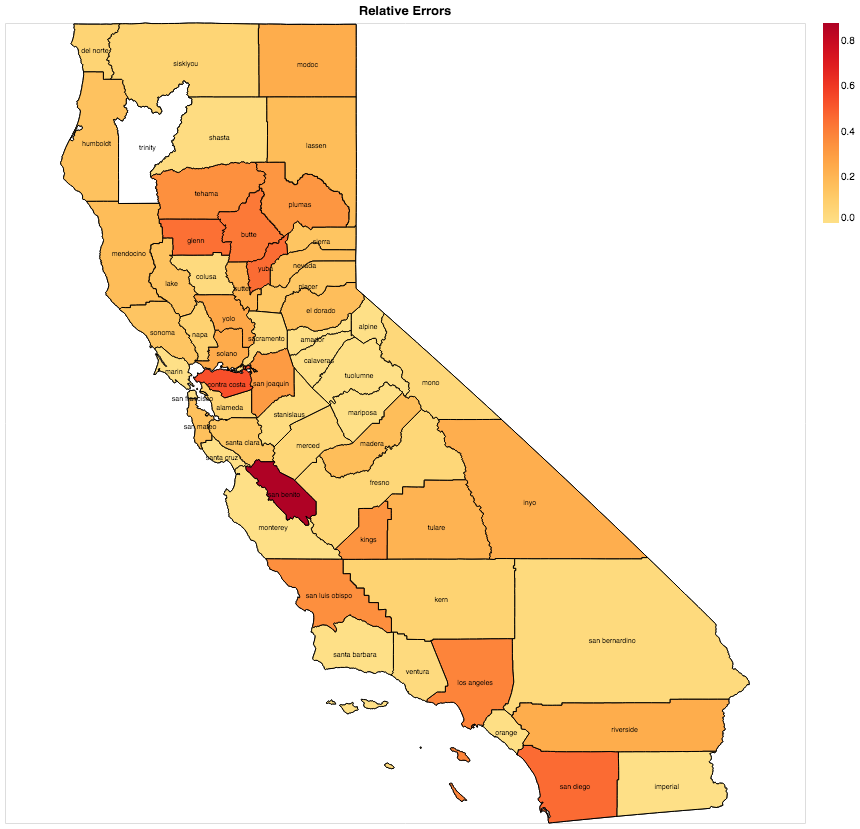

In [528]:
map_2003